## MNIST 데이터 이용해 기본적인 MLP(Multi Layer Perceptron) 설계
1. 모듈 임포트
2. 딥러닝 모델 설계 시 활용하는 장비 확인
3. MNIST 데이터 다운로드(Train, test) 분리
4. 데이터 확인
5. MLP 모델 셜계
6. Optimizer, Objective Function 설정
7. MLP 모델 학습 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
8. 학습 과정 속 검증 데이느터에 대한 모델 성능을 확인하는 함수 정의
9. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn # 1
import torch.nn.functional as F # 2
from torchvision import transforms, datasets 

1. PyTorch Module 중 딥러닝 모델을 설계할 때 필요한 함수를 모아 놓은 모듈
2. torch.nn 중 자주 이용되는 함수들

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

+ BATCH_SIZE : MLP 모델을 학습할 때 필요한 데이터 개수의 단위
  - 미니 배치 1개 단위에 대해 데이터가 32개로 구성
  - MLP 모델을 학습할 때 32개의 데이터를 이용해 첫 번째 학습을 하고 그 다음 32개의 데이터를 이용해 두번째로 학습
  - 이 과정을 마지막 데이터까지 반복해 학습 진행
+ 32개로 1개의 미니 배치를 구성하고 있으며 1개의 미니 배치로 학습 1회 진행
+ 1개의 미니 배치로 학습하는 횟수를 ***Iteration***
+ 전체 데이터를 이용해 학습을 진행한 횟수를 ***Epoch***
+ 전체 데이터가 1만개 이고 1000개의 데이터를 이용해 1개의 미니 배치를 구성한다면 1Epoch에 대해 10회의 Iteration이 발생
+ EPOCHS : 미니 배치 1개 단위로 Back Propagation을 이용해 MLP의 거중값을 업데이트
+ Epoch는 존재하고 있는 미니 배치를 전부 이용하는 횟수
+ Epoch는 하이퍼 파라미터


In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


## 3. MNIST 데이터 다운로드(Train, test) 분리

In [ ]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor()) # 1
test_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = False,
                               download = True,
                               transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,  
                                           shuffle = True) # 2

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


+ #1. MNIST 데이터는 이미지 데이터, torch 모듈의 input으로 이용되기 때문에 ToTensor() 메서드를 이용해 tensor 형태로 변경
  - 한 픽셀은 0~255의 스칼라 값으로 구성
  
    0~1로 정규화 과정 필요

+ #2. 다운로드한 MNIST 데이터 셋을 미니 배치 단위로 분리해 지정
 


## 4. 데이터 확인하기

In [ ]:
for(X_train, y_train) in train_loader:
  print('X_train :', X_train.size(), 'type :', X_train.type())
  print('y_train :', y_train.size(), 'type :', y_train.type())
  break

X_train : torch.Size([32, 1, 28, 28]) type : torch.FloatTensor
y_train : torch.Size([32]) type : torch.LongTensor


X_trian : 32개의 이미지 데이터가 1개의 미니 배치를 구성하고 가로 28 x 세로 28 픽셀로 구성되어 있으며 채널이 1이므로 그레이스케일 이미지 데이터

y_train : 32개의 이미지 데이터에 label이 1개씩 존재

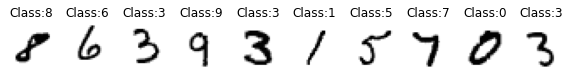

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap = 'gray_r')
  plt.title('Class:' + str(y_train[i].item()))

## 5. MLP 모델 설계


In [ ]:
class Net(nn.Module): # 1
  def __init__(self):
    super(Net, self).__init__() # 2
    self.fc1 = nn.Linear(28 * 28, 512) # 3
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
  def forward(self, x):
    x = x.view(-1, 28 * 28) # 4
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = self.fc2(x)
    x = F.sigmoid(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

+ #1 : PyTorch 모듈 내에 딥러닝 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스 생성

+ #2 : nn.Module 내에 있는 메서드를 상속받아 이용
+ #3 : 첫번째 Fully Connected Layer 정의
  - MNIST 데이터를 Input으로 사용하기 위해 28*28*1(가로*세로*채널) 크기의 노드 수를 설정 한 뒤 두번째 FC를 512개의 노드로 설정하기 때문에 output 노드 수 512
+ #4 : MLP 모델은 1차원 벡터 값을 입력받지만 MNIST 이미지 데이터는 28*28 크기의 2차원 데이터
      
      2차원 데이터를 28*28=784의 1차원 데이터로 Flatten

## 5-1 MLP에 Dropout 적용

In [ ]:
class Net(nn.Module): 
  def __init__(self):
    super(Net, self).__init__() 
    self.fc1 = nn.Linear(28 * 28, 512) 
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
    self.dropout_prob = 0.5 # 1
  def forward(self, x):
    x = x.view(-1, 28 * 28) 
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = F.dropout(x, training = self.training, p = self.dropout_prob)
    x = self.fc2(x)
    x = F.sigmoid(x)
    x = F.dropout(x, training = self.training, p = self.dropout_prob)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

+ #1 : 50 % 드롭아웃 적용

## 5-2 MLP에 Dropout + ReLU 적용

In [ ]:
class Net(nn.Module): 
  def __init__(self):
    super(Net, self).__init__() 
    self.fc1 = nn.Linear(28 * 28, 512) 
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
    self.dropout_prob = 0.5 # 1
  def forward(self, x):
    x = x.view(-1, 28 * 28) 
    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training, p = self.dropout_prob)
    x = self.fc2(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training, p = self.dropout_prob)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

## 5-3 MLP에 Dropout + ReLU + 배치 정규화 적용

## 배치 정규화(Batch Normalization)
+ 신경망에는 과적합과 Gradient Vanishing 이외에도 Interval Covariance shift라는 현상 발생
+ Interval Covariance shift : layer 마다 Input의 분포가 달라짐에 따라 학습 속도가 느려지는 현상
+ 배치 정규화를 통해 Layer의 Input 분포를 정규화해 학습 속도를 빠르게 할 수 있음



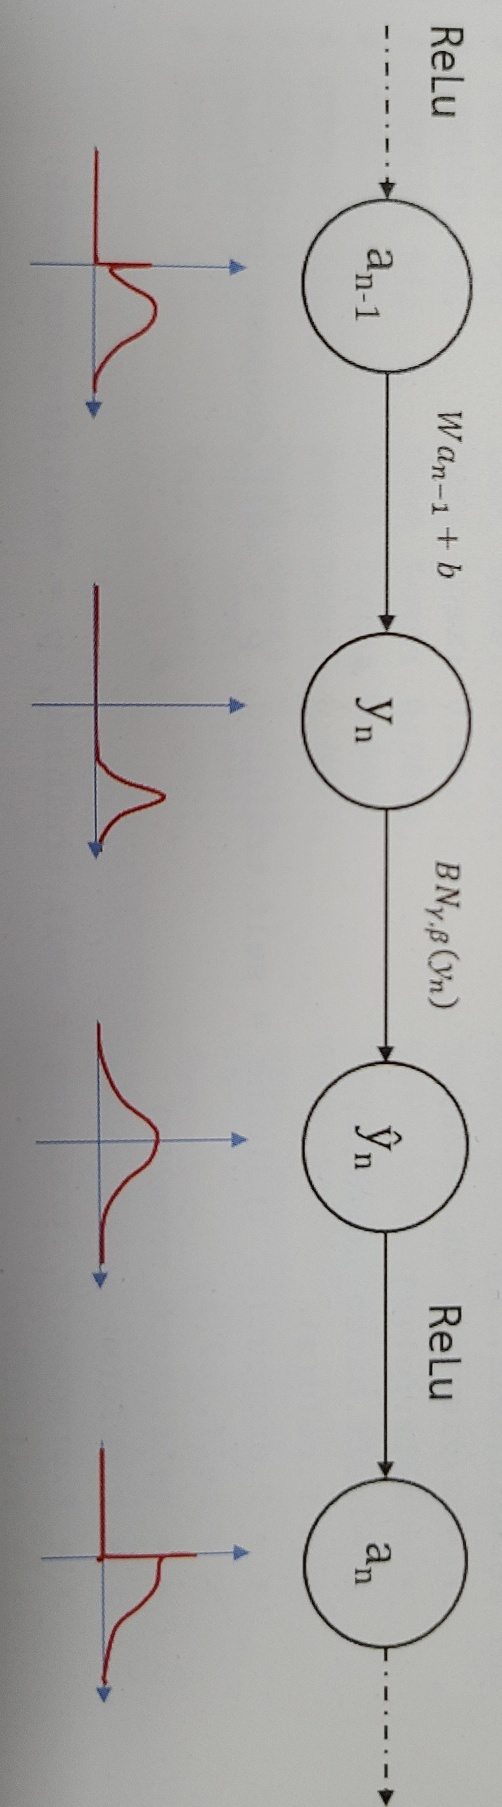

In [ ]:
class Net(nn.Module): 
  def __init__(self):
    super(Net, self).__init__() 
    self.fc1 = nn.Linear(28 * 28, 512) 
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
    self.dropout_prob = 0.5 # 1
    self.batch_norm1 = nn.BatchNorm1d(512)
    self.batch_norm2 = nn.BatchNorm1d(256)
  def forward(self, x):
    x = x.view(-1, 28 * 28) 
    x = self.fc1(x)
    x = self.batch_norm1(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training, p = self.dropout_prob)
    x = self.fc2(x)
    x = self.batch_norm2(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training, p = self.dropout_prob)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

## 6. Optimizer, Objective Function 설정

In [ ]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) # 1
criterion = nn.CrossEntropyLoss() # 2

print(Net())

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


+ #1 : Back Propagation을 이용해 파라미터를 업데이트할 때 이용하는 Optimizer를 정의
  - SGD 알고리즘을 이용하여 파라미터 업데이트
  - Optimizer 의 관성을 나타내는 momentum = 0.5 로 설정
+ #2 : MLP 모델의 output 값인 label은 원-핫 인코딩 값
  - output 값과 원-핫 인코딩 값과의 Loss는 CrossEntropy를 이용해 계산하기 위해 criterion을 nn.CrossEntropyLoss()로 설정


## 6-1 MLP에 Dropout + ReLU + 배치 정규화 + He Uniform Initialization 적용
- 5-4 에서 이어짐

## Initializaiton
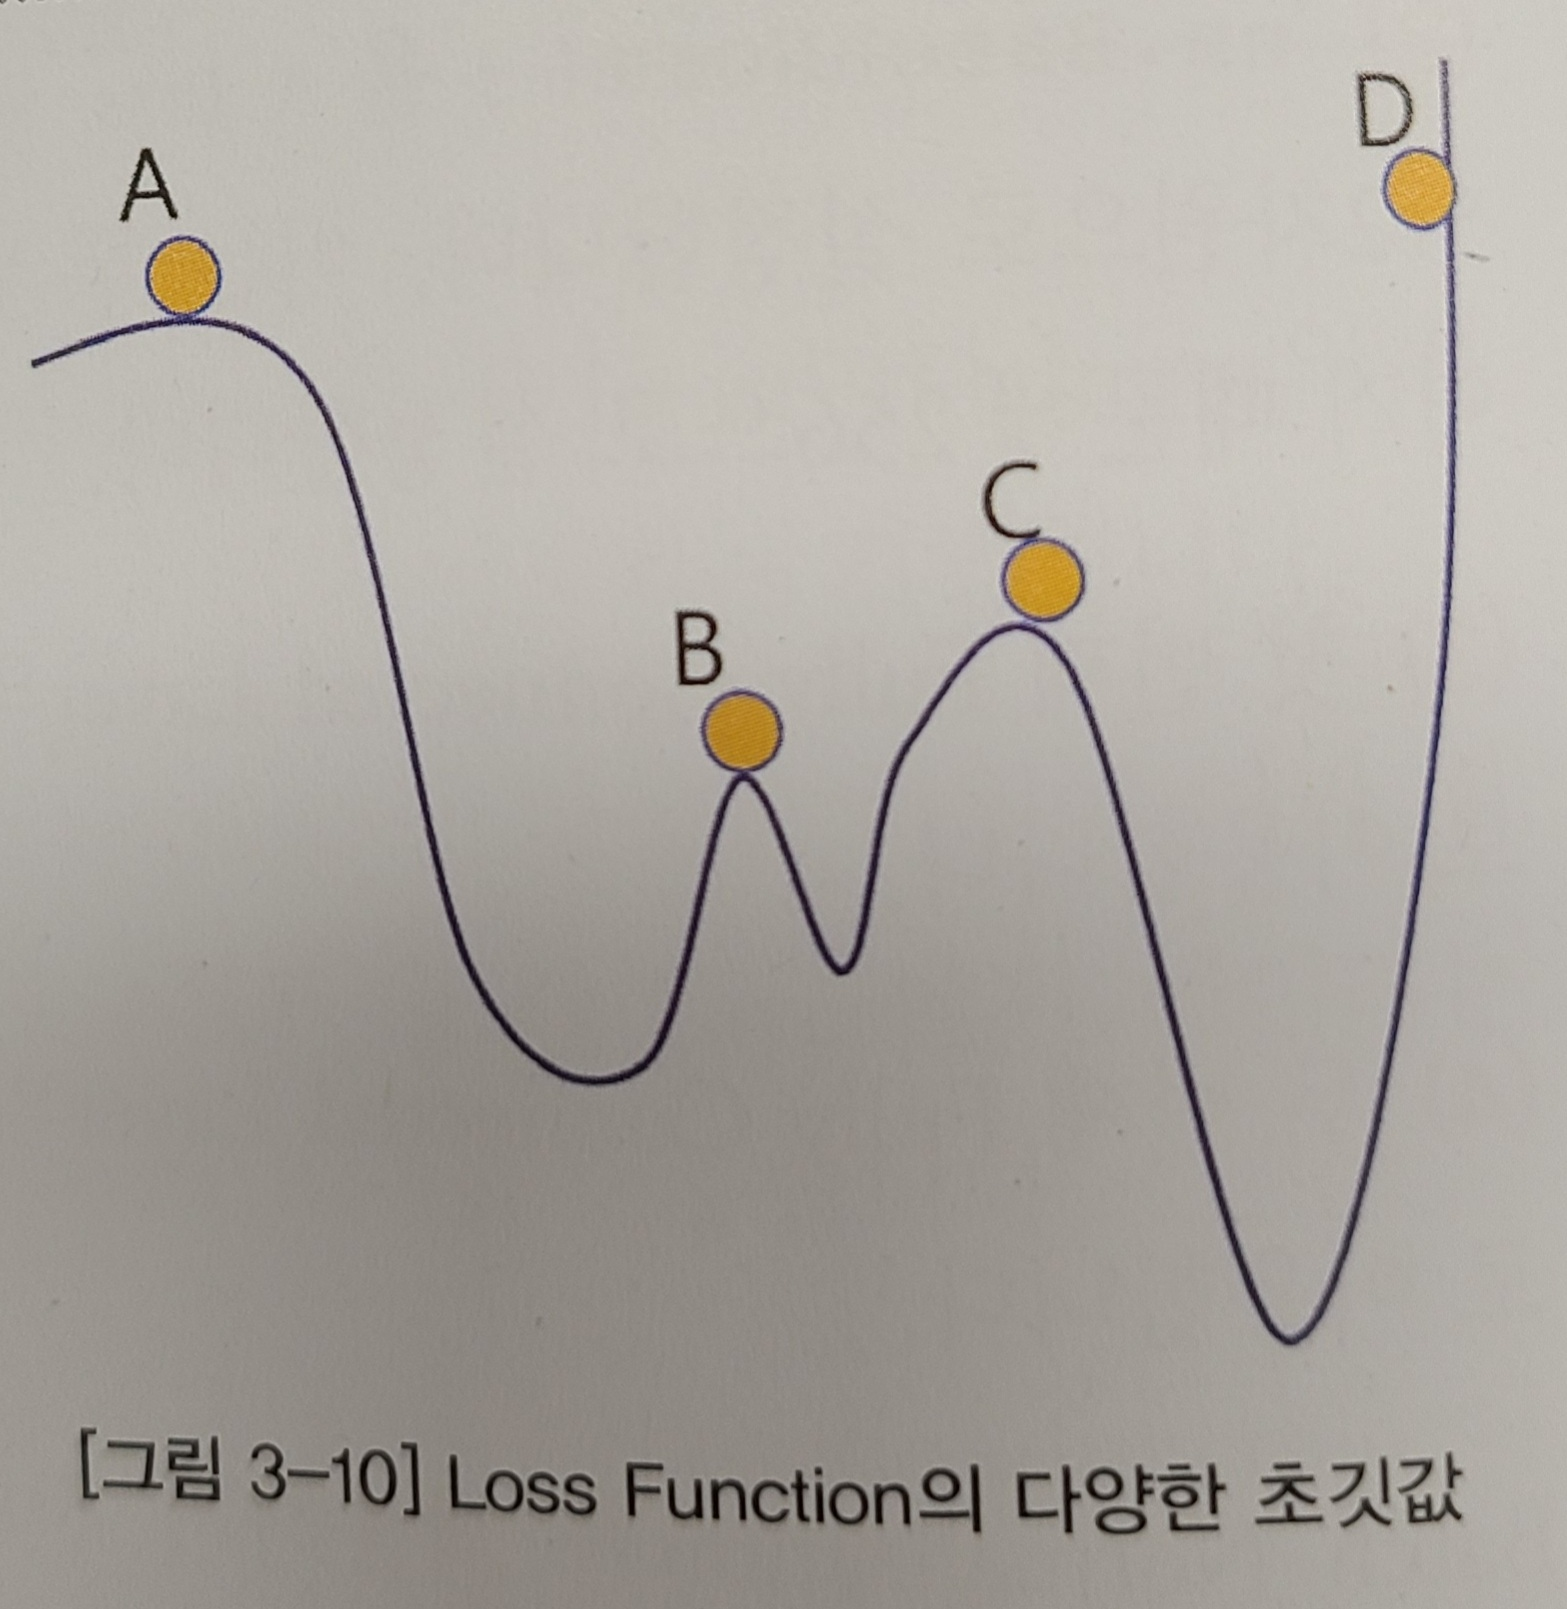
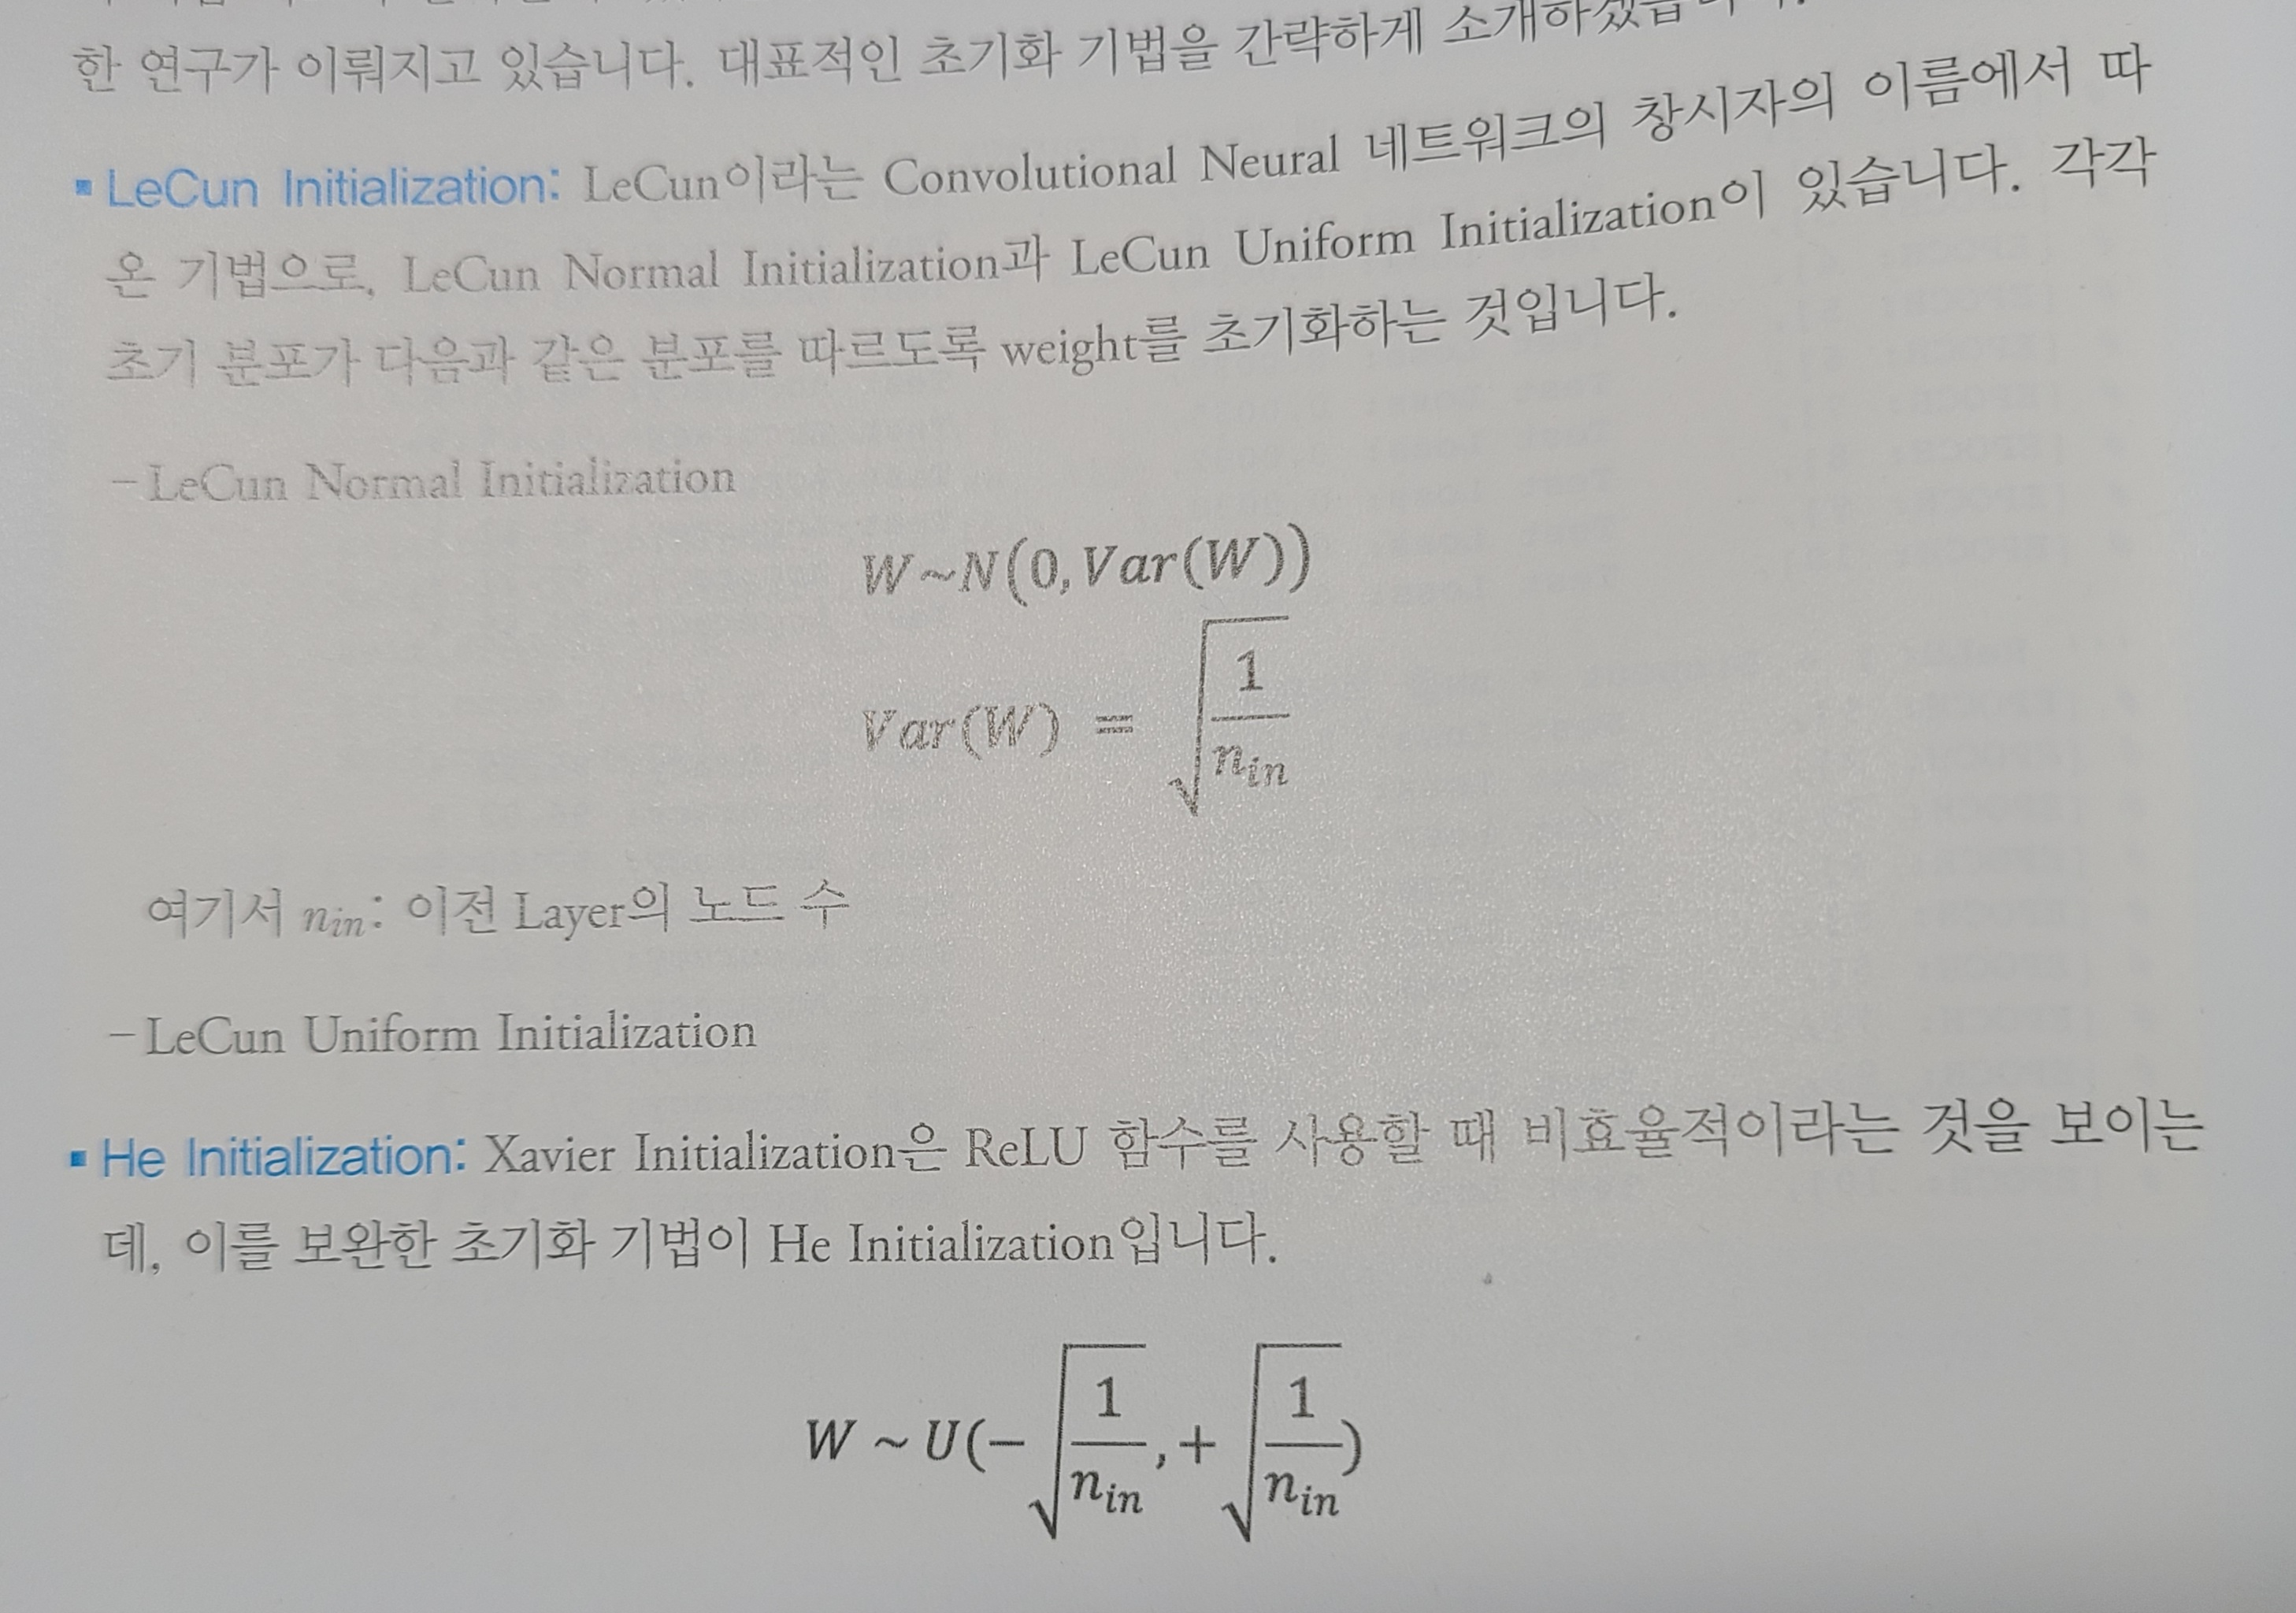

+ 신경망은 처음에 Weight를 랜덤하게 초기화 하고 Loss가 최소화 되는 부분을 찾아감
+ Weight을 초기화 할때 초기 분포로 Uniform 분포나 정규분포를 사용
+ 하지만 그림과 같이 C에서 출발하면 최소 Loss를 가장 빨리 찾을 수 있는데 A, B, D 같은 곳에서 출발하여 학습속도를 늦추게 하는 원인이됨
+ 이러한 문제를 해결하기 위해 신경망 초기화 기법에 대한 다양한 연구가 이루어 지고 있음
+ 여기서는 He Initialization 방법 사용

In [ ]:
# 6-1 Optimizer, Objective Function 설정
import torch.nn.init as init
def weight_init(m):
  if isinstance(m, nn.Linear): # 1
    init.kaiming_uniform_(m.weight.data) # 2

model = Net().to(DEVICE)
model.apply(weight_init) # 3
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) # 1
criterion = nn.CrossEntropyLoss() 

- #1. MLP 모델 중 nn.Linear에 해당하는 파라미터 값에 대해서만 지정
- #2. nn.Linear에 해당하는 파라미터 값에 대해 he_initialization을 이용해 파라미터 값을 초기화
- 

## 6-2 MLP에 Dropout + ReLU + 배치 정규화 + He Uniform Initialization + Adam 적용

## Optimizer
+ Batch 단위로 Back Propagation 하는 과정을 Stochastic Gradient Descent(SGD)라고 하고 이러한 과정을 'Optimization'이라고 함
+ SGD외에도 SGD의 단점을 보완하기 위한 다양한 Optimizer가 있음
+ Momentum
+ Nesterov Accelerated Gradient(NAG)
+ Adaptive Gradient(Adagrad) : '가보지 않은 곳은 많이 움직이고 가본 곳은 조금 씩 움직이자'라는 아이디어에서 나온 Optimizer
+ RMSProp : Adagrad의 단점을 보완
+ Adaptive Delta(Adadelta)
+ Adaptive Moment Estimation(Adam) : Adam은 딥러닝 모델을 디자인할 때 기본적으로 가장 많이 사용하는 Optimizer.
  
  RMSProp 과 Momentum 방식의 특징을 결합한 방법
+ Rectified Adam Optimizer(RAdam)

+ 딥러닝 모델 디자인에는 다양한 요소가 필요
+ Hidden Layer
+ Hidden 노드 수
+ Activation 함수
+ Initialization 기법
+ Optimizer
+ 등등..
+ 기본적으로 많이 사용하는 기법은 있지만, 각 기법이 가지고 있는 장,단점이 있기 때문에 딥러닝 모델을 디자인할 때 여러가지 방식으로 시도해보는 것이 좋음

In [ ]:
# 6-2 MLP에 Dropout + ReLU + 배치 정규화 + He Uniform Initialization + Adam 적용
import torch.nn.init as init
def weight_init(m):
  if isinstance(m, nn.Linear): # 1
    init.kaiming_uniform_(m.weight.data) # 2

model = Net().to(DEVICE)
model.apply(weight_init) # 3
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # 1
criterion = nn.CrossEntropyLoss() 

## 7. MLP 모델 학습 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 

In [ ]:
def train(Net, train_loader, optimizer, log_interval):
  model.train()
  #Net().trian()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad() # 1
    output = model(image)
    loss = criterion(output, label)
    loss.backward() # 2
    optimizer.step() # 3

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset),
          100. * batch_idx / len(train_loader),
          loss.item()
      ))

+ #1 : 과거에 이용한 미니 배치에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss와 Gradient 값이 optimizer값에 할당되어 있으므로 optimizer의 Gradient를 초기화
+ #2 : Loss값을 계산한 결과를 바탕으로 Back Propagation을 통해 계싼된 Gradient 값을 각 파라미터에 할당
+ #3 : 각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값을 업데이트

# 8. 학습 과정 속 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [ ]:
def evaluate(model, test_loader):
  model.eval() # 1
  test_loss = 0
  correct = 0

  with torch.no_grad(): # 2
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item() # 3
      prediction = output.max(1, keepdim = True)[1] # 4
      correct += prediction.eq(label.view_as(prediction)).sum().item() # 5
  
  test_loss /= len(test_loader.dataset) # 6  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

+ #1 : 학습 과정 또는 학습이 완료된 상태에서 MLP모델의 성능을 평가하기 위해 evaluate 함수 정의
+ #2 : 모델 평가 단계에서 Gradient를 통해 파라미터 값이 업데이트 되는 현상을 방지
+ #3 : output과 label의 CrossEntropy를 이용해 Loss값 계산
+ #4 : 계산된 Output은 크기가 10인 벡터, 이 중 가장 큰 값을 예측값으로 저장
+ #5 : 예측값과 label값이 같으면 correct에 더해 올바르게 예측한 횟수를 저장
+ #6 : 현재까지의 test_loss의 값을 test_loader 내에 존재하는 미니 배치 개수만큼 나누어 평균 Loss 값 계산


## 9. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인

In [ ]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH : {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 3.138303
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.401175
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.540220
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.182344
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.188960
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.565552
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.111294
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.197845
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.216180
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.146350

[EPOCH : 1], 	Test Loss: 0.0040, 	Test Accuracy: 95.94 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.206377
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.373715
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.432947
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.217559
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.075338
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.305262
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.327297
Train Epoch: 2 [44